<a href="https://colab.research.google.com/github/Moi6-23/pytorch-ssd/blob/master/MobilenetPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Guía GOOGLE COLAB - JETSON NANO, implementación del modelo Pytorch por Moisés Arias en base al repositorio "https://github.com/qfgaohao/pytorch-ssd"

##Detectar Si el entorno está con GPU

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


'/device:GPU:0'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2914177559841525401
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10460644907397848228
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

##Instalación de Pytorch

In [3]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


##Paquetes para usar el dataset Open Image

In [4]:
!pip install boto3
!pip install urllib3

##Importación de paquetes de trabajo

In [5]:
import cv2
import torch
import pandas
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

###Repositorio del modelo

In [7]:
##!git clone https://github.com/qfgaohao/pytorch-ssd.git
!git clone https://github.com/Moi6-23/pytorch-ssd.git
!ls 

fatal: destination path 'pytorch-ssd' already exists and is not an empty directory.
pytorch-ssd  sample_data


##Descarga de pesos pre-entrenados y archivo txt con etiquetas

In [8]:
%cd pytorch-ssd/models/
!wget  https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth
!wget https://storage.googleapis.com/models-hao/voc-model-labels.txt

/content/pytorch-ssd/models
--2021-12-10 17:55:35--  https://storage.googleapis.com/models-hao/mobilenet-v1-ssd-mp-0_675.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37995286 (36M) [application/octet-stream]
Saving to: ‘mobilenet-v1-ssd-mp-0_675.pth’

mobilenet-v1-ssd-mp 100%[===================>]  36.23M   122MB/s    in 0.3s    

2021-12-10 17:55:36 (122 MB/s) - ‘mobilenet-v1-ssd-mp-0_675.pth’ saved [37995286/37995286]

--2021-12-10 17:55:36--  https://storage.googleapis.com/models-hao/voc-model-labels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK


###Realizar inferencia en una imagen con un "perro"

Descargar y mostrar imagen

In [14]:
%cd pytorch-ssd/
%ls

[Errno 2] No such file or directory: 'pytorch-ssd/'
/content/pytorch-ssd
convert_to_caffe2_models.py  prune_alexnet.py
dog.jpg                      README.md
draw_eval_results.py         readme_ssd_example.jpg
eval_ssd.py                  run_ssd_example2.py
extract_tf_weights.py        run_ssd_example.py
gun.jpg                      run_ssd_live_caffe2.py
LICENSE                      run_ssd_live_demo.py
models/                      train_ssd.py
onnx_exportJetson.py         translate_tf_mobilenetv1.py
openImageJetson.py           vision/
open_images_downloader.py    visual_tf_models.py


--2021-12-10 18:00:02--  https://i.ibb.co/sF9wL4y/dog.jpg
Resolving i.ibb.co (i.ibb.co)... 104.238.221.84, 104.194.8.196, 104.238.221.171, ...
Connecting to i.ibb.co (i.ibb.co)|104.238.221.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64315 (63K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  62.81K  --.-KB/s    in 0.09s   

2021-12-10 18:00:02 (678 KB/s) - ‘dog.jpg’ saved [64315/64315]



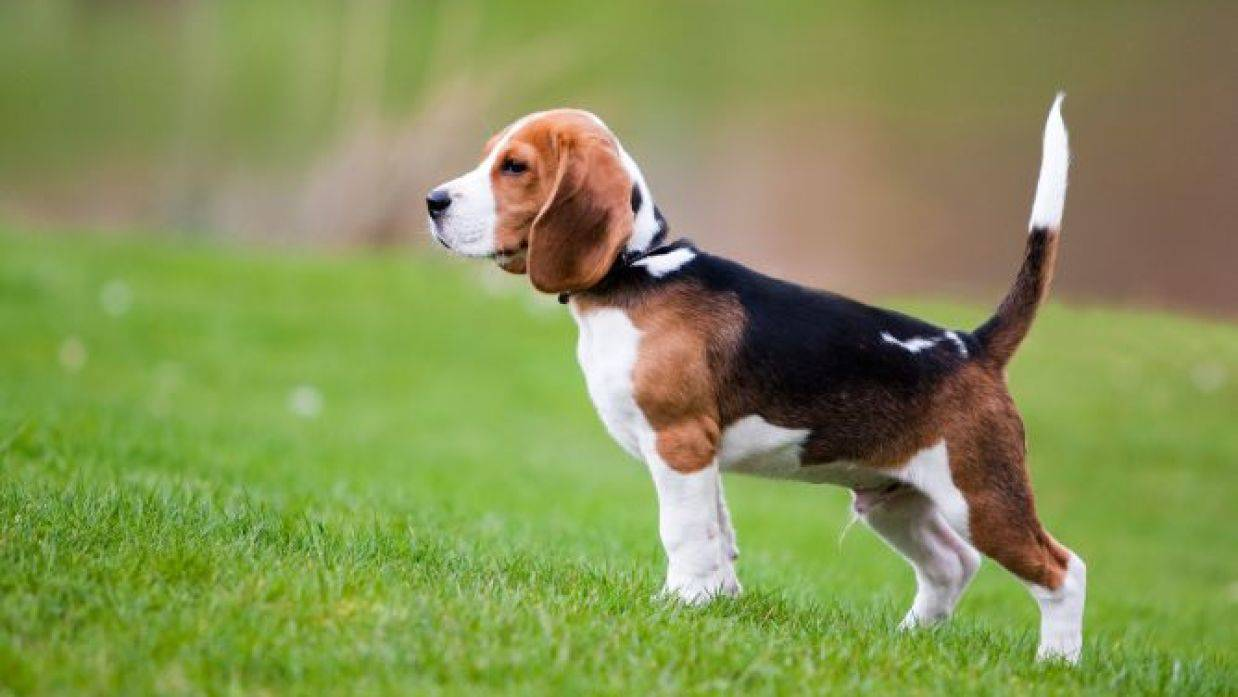

In [16]:
 from google.colab.patches import cv2_imshow
!wget https://i.ibb.co/sF9wL4y/dog.jpg
img = cv2.imread('dog.jpg')
cv2_imshow(img)

Código para realizar la inferencia

In [17]:

!python run_ssd_example2.py mb1-ssd models/mobilenet-v1-ssd-mp-0_675.pth models/voc-model-labels.txt dog.jpg

Inference time:  0.015295743942260742
Found 1 objects. The output image is run_ssd_example_output.jpg


Mostrar imagen de salida

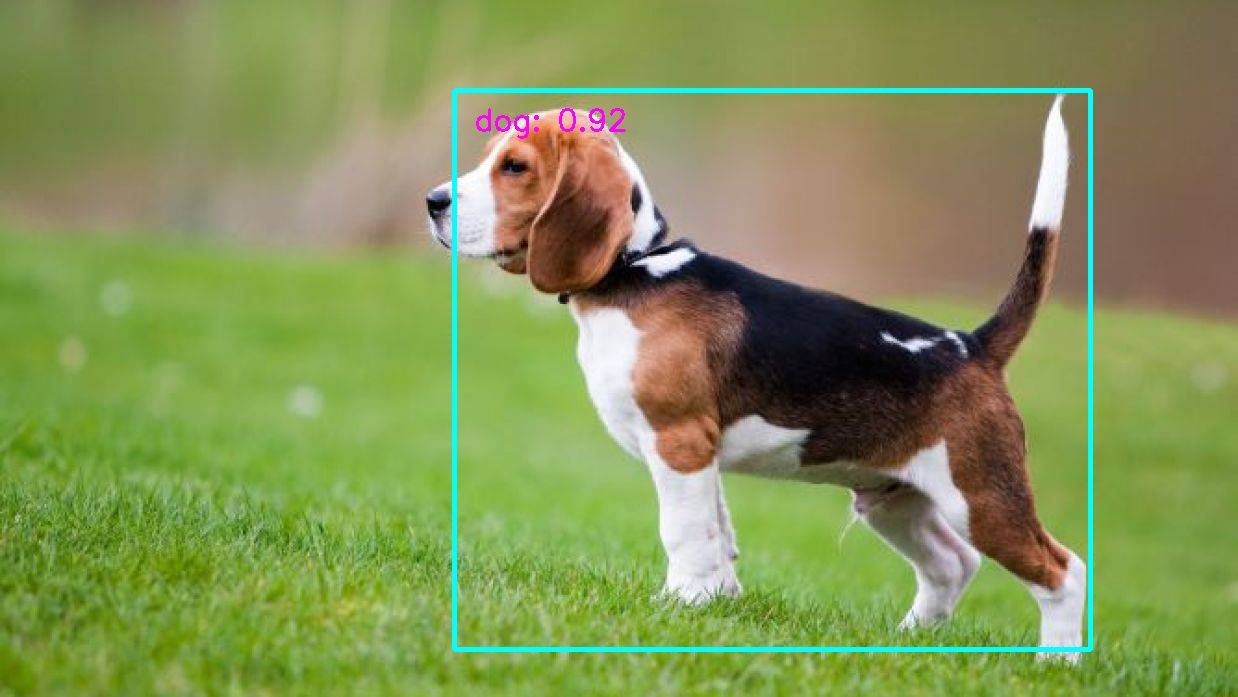

In [18]:
img = cv2.imread('run_ssd_example_output.jpg')
cv2_imshow(img)

#**Entrenamiento** del modelo

Descarga de datos de open Images "https://storage.googleapis.com/openimages/web/index.html"

**--max-images** limita el conjunto de datos total al número especificado de imágenes, manteniendo la distribución de imágenes por clase aproximadamente igual que el conjunto de datos original. Si una clase tiene más imágenes que otra, la proporción seguirá siendo aproximadamente la misma.

**--max-annotations-per-class** limita cada clase al número especificado de cuadros delimitadores, y si una clase tiene menos de ese número disponible, se utilizarán todos sus datos, lo que es útil si la distribución de datos está desequilibrada entre clases.

In [19]:
!mkdir data
!python openImageJetson.py --class-names "Headphones" --data=data/open_images

2021-12-10 18:03:14 - Download https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv.
2021-12-10 18:03:14 - Requested 1 classes, found 1 classes
2021-12-10 18:03:14 - Download https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv.
2021-12-10 18:03:29 - Read annotation file data/open_images/train-annotations-bbox.csv
2021-12-10 18:03:49 - Available train images:  1060
2021-12-10 18:03:49 - Available train boxes:   1244

2021-12-10 18:03:49 - Download https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv.
2021-12-10 18:03:50 - Read annotation file data/open_images/validation-annotations-bbox.csv
2021-12-10 18:03:50 - Available validation images:  34
2021-12-10 18:03:50 - Available validation boxes:   35

2021-12-10 18:03:50 - Download https://storage.googleapis.com/openimages/2018_04/test/test-annotations-bbox.csv.
2021-12-10 18:03:52 - Read annotation file data/open_images/test-annotations-bbo

Creación del archivo **labels.txt** donde se encuentran las etiquetas descargadas, **parametro:** --class-names "Headphones"  

En el comando printf se agrega el contenido, en caso de tener más etiquetas seguir la secuencia: 
f.write('Background')
f.write('\n' + 'className1')
f.write('\n' + 'className2')
f.write('\n' + 'className3')
.
.
.
f.close()

total 912
drwxr-xr-x  2 root root   4096 Dec 10 19:07 conversionOnnx
-rw-r--r--  1 root root   2390 Dec 10 17:55 convert_to_caffe2_models.py
drwxr-xr-x  3 root root   4096 Dec 10 18:03 data
-rw-r--r--  1 root root  64315 Dec 10 17:41 dog.jpg
-rw-r--r--  1 root root   1121 Dec 10 17:55 draw_eval_results.py
-rw-r--r--  1 root root  10368 Dec 10 17:55 eval_ssd.py
-rw-r--r--  1 root root    967 Dec 10 17:55 extract_tf_weights.py
-rw-r--r--  1 root root  93875 Dec 10 17:55 gun.jpg
-rw-r--r--  1 root root      0 Dec 10 19:09 labels.txt
-rw-r--r--  1 root root   1064 Dec 10 17:55 LICENSE
drwxr-xr-x  3 root root   4096 Dec 10 19:06 models
-rw-r--r--  1 root root   4374 Dec 10 17:55 onnx_exportJetson.py
-rw-r--r--  1 root root  11191 Dec 10 17:55 openImageJetson.py
-rw-r--r--  1 root root   7415 Dec 10 17:55 open_images_downloader.py
-rw-r--r--  1 root root  10500 Dec 10 17:55 prune_alexnet.py
-rw-r--r--  1 root root   9845 Dec 10 17:55 README.md
-rw-r--r--  1 root root 484422 Dec 10 17:55 read

In [29]:
%cd /content/pytorch-ssd/models/
!touch labels.txt
f = open ('labels.txt','w')
f.write('Background')
f.write('\n' + 'Headphones')
f.close()

!cat labels.txt

/content/pytorch-ssd/models
Background
Headphones

##Entrenamiento del modelo MobilenetV1-SSD con el dataset descargado de open images

Cada 5 epocas se guarda un archivo .pth, este se almacena en content/pytorch-ssd/models

In [21]:
!python train_ssd.py --dataset_type open_images --datasets data/open_images --net mb1-ssd --pretrained_ssd models/mobilenet-v1-ssd-mp-0_675.pth --scheduler cosine --lr 0.01 --t_max 100 --validation_epochs 5 --num_epochs 50 --base_net_lr 0.001  --batch_size 5


2021-12-10 18:06:34,676 - root - INFO - Use Cuda.
2021-12-10 18:06:34,676 - root - INFO - Namespace(balance_data=False, base_net=None, base_net_lr=0.001, batch_size=5, checkpoint_folder='models/', dataset_type='open_images', datasets=['data/open_images'], debug_steps=100, extra_layers_lr=None, freeze_base_net=False, freeze_net=False, gamma=0.1, lr=0.01, mb2_width_mult=1.0, milestones='80,100', momentum=0.9, net='mb1-ssd', num_epochs=50, num_workers=4, pretrained_ssd='models/mobilenet-v1-ssd-mp-0_675.pth', resume=None, scheduler='cosine', t_max=100.0, use_cuda=True, validation_dataset=None, validation_epochs=5, weight_decay=0.0005)
2021-12-10 18:06:34,677 - root - INFO - Prepare training datasets.
2021-12-10 18:06:35,714 - root - INFO - Dataset Summary:Number of Images: 1060
Minimum Number of Images for a Class: -1
Label Distribution:
	Headphones: 1244
2021-12-10 18:06:35,715 - root - INFO - Stored labels into file models/open-images-model-labels.txt.
2021-12-10 18:06:35,715 - root - IN

###Conversión a ONNX, de este modo tiene un mejor rendimiento en la Jetson

Creación de carpeta para el archivo .pth y .txt

In [22]:
%cd /content/pytorch-ssd/
!mkdir conversionOnnx

[Errno 2] No such file or directory: 'pytorch-ssd/'
/content/pytorch-ssd


Copiar el último archivo de entrenamiento y el archivo donde se encuentran las clases a la carpeta recien creada ""conversionOnnx". **Verificar que el nombre corresponda al .pth** que se quiere realizar la conversión 

In [36]:
%cd /content/pytorch-ssd/models/
!cp /content/pytorch-ssd/models/mb1-ssd-Epoch-49-Loss-2.9046811917248894.pth /content/pytorch-ssd/conversionOnnx/
!cp /content/pytorch-ssd/models/labels.txt /content/pytorch-ssd/conversionOnnx/

/content/pytorch-ssd/models


Script para realizar la conversión

In [37]:
%cd /content/pytorch-ssd/
!python onnx_exportJetson.py --model-dir=conversionOnnx

/content/pytorch-ssd
Namespace(batch_size=1, height=300, input='', labels='labels.txt', model_dir='conversionOnnx', net='ssd-mobilenet', output='', width=300)
running on device cuda:0
found best checkpoint with loss 2.904681 (conversionOnnx/mb1-ssd-Epoch-49-Loss-2.9046811917248894.pth)
creating network:  ssd-mobilenet
num classes:       2
loading checkpoint:  conversionOnnx/mb1-ssd-Epoch-49-Loss-2.9046811917248894.pth
exporting model to ONNX...
graph(%input_0 : Float(1, 3, 300, 300),
      %base_net.0.0.weight : Float(32, 3, 3, 3),
      %base_net.0.1.weight : Float(32),
      %base_net.0.1.bias : Float(32),
      %base_net.0.1.running_mean : Float(32),
      %base_net.0.1.running_var : Float(32),
      %base_net.0.1.num_batches_tracked : Long(),
      %base_net.1.0.weight : Float(32, 1, 3, 3),
      %base_net.1.1.weight : Float(32),
      %base_net.1.1.bias : Float(32),
      %base_net.1.1.running_mean : Float(32),
      %base_net.1.1.running_var : Float(32),
      %base_net.1.1.num_b

##**Descarga** de los pesos convertidos y el archivo de labels.txt

Estos son los **archivo**s que se llevan a la jetson nano para incluirlos en el modelo, cabe destacar que se debe haber realizado la instalación de jetson inferences localmente de manera correcta: https://github.com/dusty-nv/jetson-inference/blob/master/docs/building-repo-2.md

En **--model y --labels** se especifica la ubicación en donde se agreguen los documentos, sea documentos, descargas, etc. 

En caso de realizar el entrenamiento directamente en la jetson:
https://github.com/dusty-nv/jetson-inference/blob/master/docs/pytorch-ssd.md

**Ejemplo:**
detectnet --model=models/fruit/ssd-mobilenet.onnx --labels=models/fruit/labels.txt --input-blob=input_0 --output-cvg=scores --output-bbox=boxes            csi://0


In [38]:
%cd /content/pytorch-ssd/conversionOnnx/
from google.colab import files
files.download('ssd-mobilenet.onnx') 
files.download('labels.txt') 

/content/pytorch-ssd/conversionOnnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>